In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib
import numpy as np
import pickle
import glob
import os
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import warnings

from tensorflow.keras.callbacks import ModelCheckpoint
from scipy.stats import norm
from timeit import default_timer as timer
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from gnn_uq.load_data import load_data
from gnn_uq.gnn_model import gnn, nll, RegressionUQSpace
from gnn_uq.result import sort_best_RE, get_result, get_result_random

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

NAME = ['Lipo', 'ESOL', 'FreeSolv', 'QM7']
COLOR = []
cycle = pplt.Cycle('ggplot')
cycle2 = pplt.Cycle('Dark2')
for c in cycle:
    COLOR.append(c['color'])
for c in cycle2:
    COLOR.append(c['color'])

pplt.rc.cycle = 'ggplot'

### ROOT DIR
Change to your own dir.

In [3]:
ROOT_DIR  = "/scratch/gpfs/sj0161/autognnuq/"

### Search Trajectories

# seed 0 search reward collected ...
# seed 1 search reward collected ...
# seed 2 search reward collected ...
# seed 3 search reward collected ...
# seed 4 search reward collected ...
# seed 5 search reward collected ...
# seed 6 search reward collected ...
# seed 7 search reward collected ...


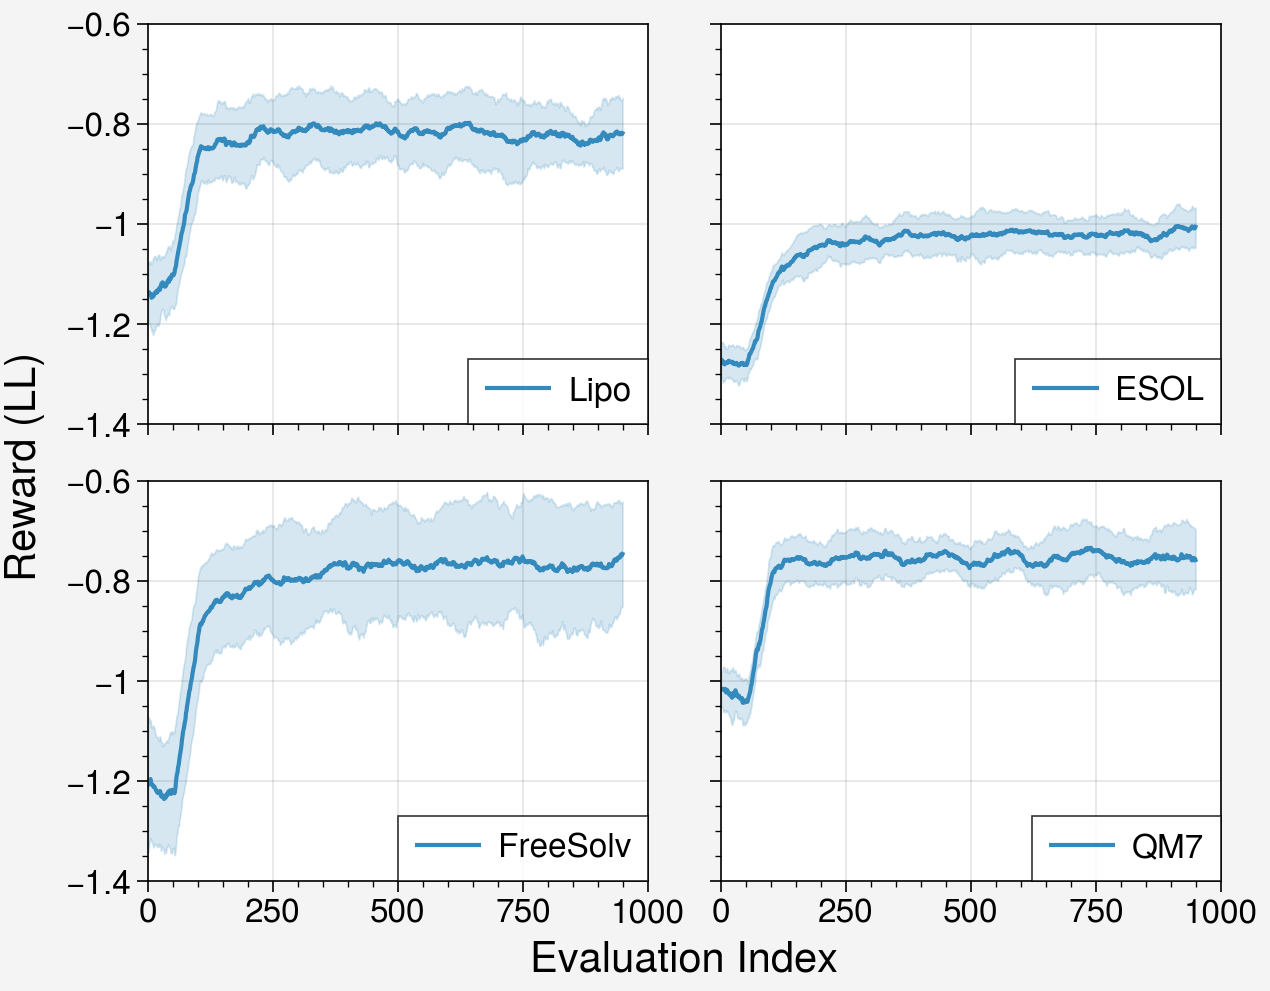

In [7]:
labels = ['Delaney', 'Lipo', 'FreeSolv', 'QM7']
seeds  = 8
objs   = [[[] for _ in range(seeds)] for _ in range(len(labels))]

for seed in range(seeds):
    dfs = [pd.read_csv(os.path.join(ROOT_DIR, 
                                    f'NEW_RE_{label.lower()}_random_{seed}_split_523/results.csv')) for label in labels]
    for i, df in enumerate(dfs):
        obj = df.objective.values
        prev_value = None
        
        for j in range(len(obj)):
            if obj[j] <= -2:
                if prev_value is not None:
                    obj[j] = prev_value
            else:
                prev_value = obj[j]
                
        obj_smooth    = np.convolve(obj, np.ones(50)/50, mode='valid')
        objs[i][seed] = obj_smooth[:950]
        
    print(f"# seed {seed} search reward collected ...")
        

fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=True, refwidth=2.5, refheight=2)

for i, obj in enumerate(objs):
    obj_mean = np.mean(obj, axis=0)
    obj_std  = np.std(obj,  axis=0)
    xx       = np.arange(len(obj_mean))

    ax[i].plot(xx, obj_mean, label=NAME[i], color=COLOR[1])
    ax[i].fill_between(xx, obj_mean - obj_std, obj_mean + obj_std, alpha=0.2, color=COLOR[1])
    ax[i].legend(loc=4, prop={'size': 12})
    ax[i].format(xlabel='Evaluation Index',
                 xlim=[0, 1000],
                 xticklabelsize=12, 
                 yticklabelsize=12, 
                 xlabelsize=15, 
                 ylabelsize=15,
                 ylim = [-1.4, -0.6],
                 xticks=[0, 250, 500, 750, 1000])
    
fig.text(0.02, 0.53, 'Reward (LL)', va='center', ha='center', rotation='vertical', fontsize=15);
    
# fig.save('../result/fig/search_reward.svg', dpi=300, bbox_inches='tight')

### AutoGNNUQ Result Pickle

In [9]:
datasets    = ['lipo', 'delaney', 'freesolv', 'qm7']
split_types = ['523', '811']
range_seeds = range(8)

result_file = "../result/val_test_result.pickle"

if os.path.exists(result_file):
    print(f"# result file exists ...")
    
else:
    print(f"# result file does not exist ...")
    out_result = get_result(ROOT_DIR, datasets, split_types, range_seeds)

    with open(result_file, "wb") as handle:
        pickle.dump(out_result, handle)

# result file exists ...


### Random Ensemble Result Pickle

In [12]:
datasets    = ['lipo', 'delaney', 'freesolv', 'qm7']
split_types = ['523', '811']
range_seeds = range(8)

result_file = "../result/val_test_result_random.pickle"

if os.path.exists(result_file):
    print(f"# result file exists ...")
    
else:
    print(f"# result file does not exist ...")
    out_result = get_result(ROOT_DIR, datasets, split_types, range_seeds)

    with open(result_file, "wb") as handle:
        pickle.dump(out_result, handle)

# result file exists ...


### AutoGNNUQ Regression Performance

In [14]:
with open("../result/val_test_result.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("../result/val_test_result_random.pickle", "rb") as handle:
    result_random = pickle.load(handle)
    
print(f"# results loaded ...")

# results loaded ...


In [21]:
print("# AutoGNNUQ Regression Results")
for dataset in ['lipo', 'delaney', 'freesolv', 'qm7']:
    metric_total = np.zeros(8)
    for seed in range(8):
        y_test_temp = np.copy(result[(dataset, '523', seed)][0])
        y_pred_temp = np.copy(result[(dataset, '523', seed)][1])
        
        if dataset == 'qm7':
            metric_temp = skm.mean_absolute_error(y_test_temp, y_pred_temp)
            metric    = "MAE"
        else:
            metric_temp = skm.mean_squared_error(y_test_temp, y_pred_temp) ** 0.5
            metric    = "RMSE"
            
        metric_total[seed] = metric_temp
    
    print(f"# {dataset:<8} {metric:<4}: {metric_total.mean():<8.5g} +/- {metric_total.std():<8.5g}")

# AutoGNNUQ Regression Results
# lipo     RMSE: 0.64067  +/- 0.016915
# delaney  RMSE: 0.73962  +/- 0.061068
# freesolv RMSE: 1.3182   +/- 0.28647 
# qm7      MAE : 47.464   +/- 2.0722  


In [23]:
print("# Random Ensemble Results")
for dataset in ['lipo', 'delaney', 'freesolv', 'qm7']:
    metric_total = np.zeros(8)
    for seed in range(8):
        y_test_temp = np.copy(result_random[(dataset, '523', seed)][0])
        y_pred_temp = np.copy(result_random[(dataset, '523', seed)][1])
        
        if dataset == 'qm7':
            metric_temp = skm.mean_absolute_error(y_test_temp, y_pred_temp)
            metric    = "MAE"
        else:
            metric_temp = skm.mean_squared_error(y_test_temp, y_pred_temp) ** 0.5
            metric    = "RMSE"
            
        metric_total[seed] = metric_temp
    
    print(f"# {dataset:<8} {metric:<4}: {metric_total.mean():<8.5g} +/- {metric_total.std():<8.5g}")

# Random Ensemble Results
# lipo     RMSE: 0.74556  +/- 0.022631
# delaney  RMSE: 0.79422  +/- 0.040625
# freesolv RMSE: 1.4292   +/- 0.12271 
# qm7      MAE : 58.593   +/- 6.6045  


### Regression Parity Plots

# seed 0 parity plot done ...
# seed 1 parity plot done ...
# seed 2 parity plot done ...
# seed 3 parity plot done ...
# seed 4 parity plot done ...
# seed 5 parity plot done ...
# seed 6 parity plot done ...
# seed 7 parity plot done ...


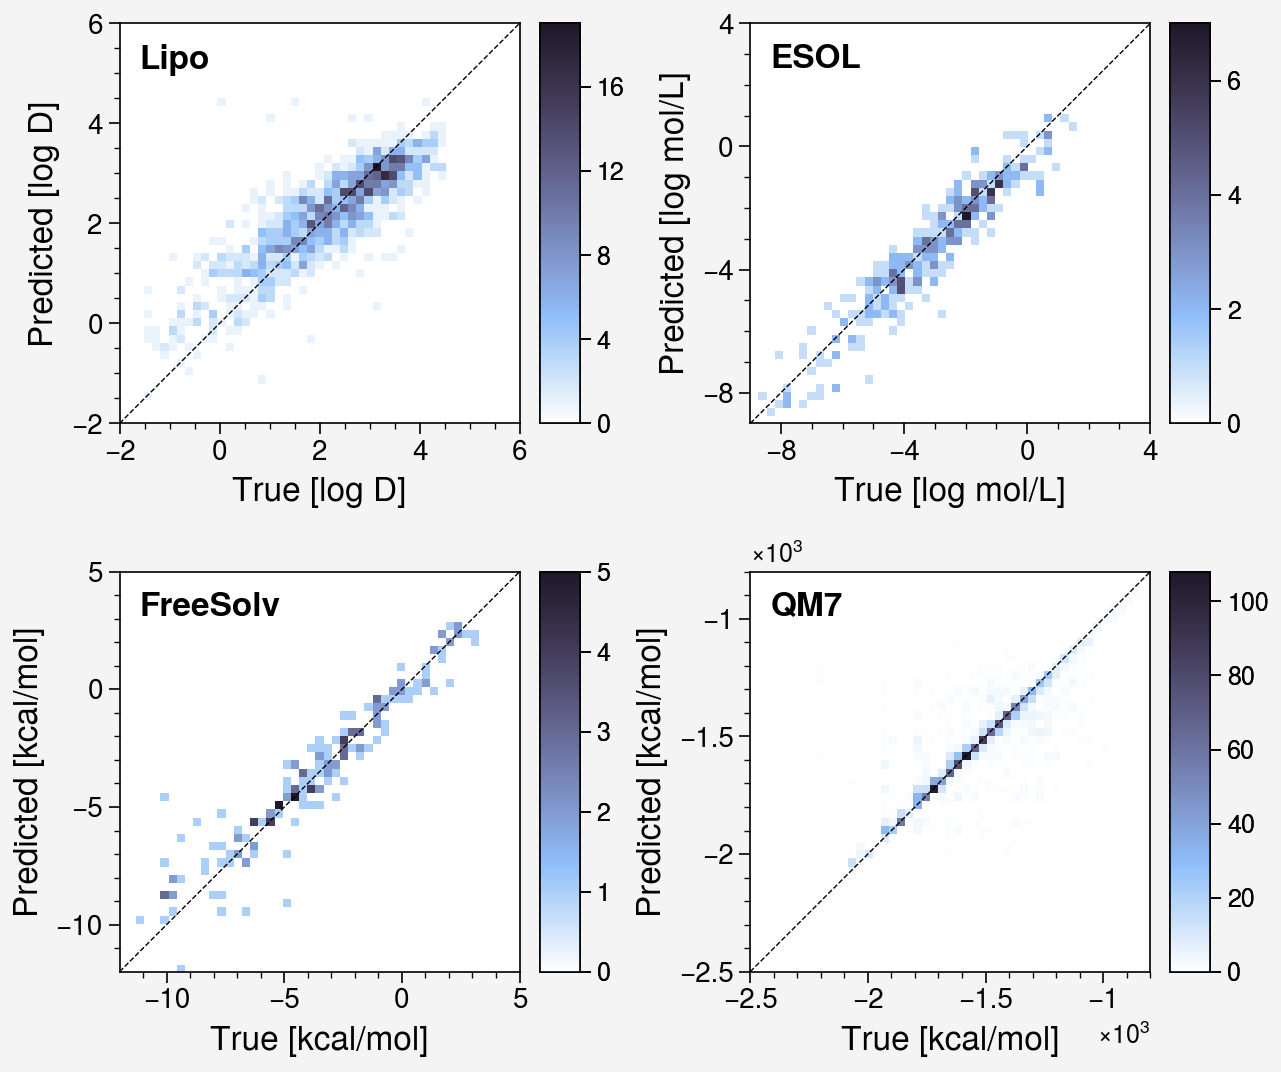

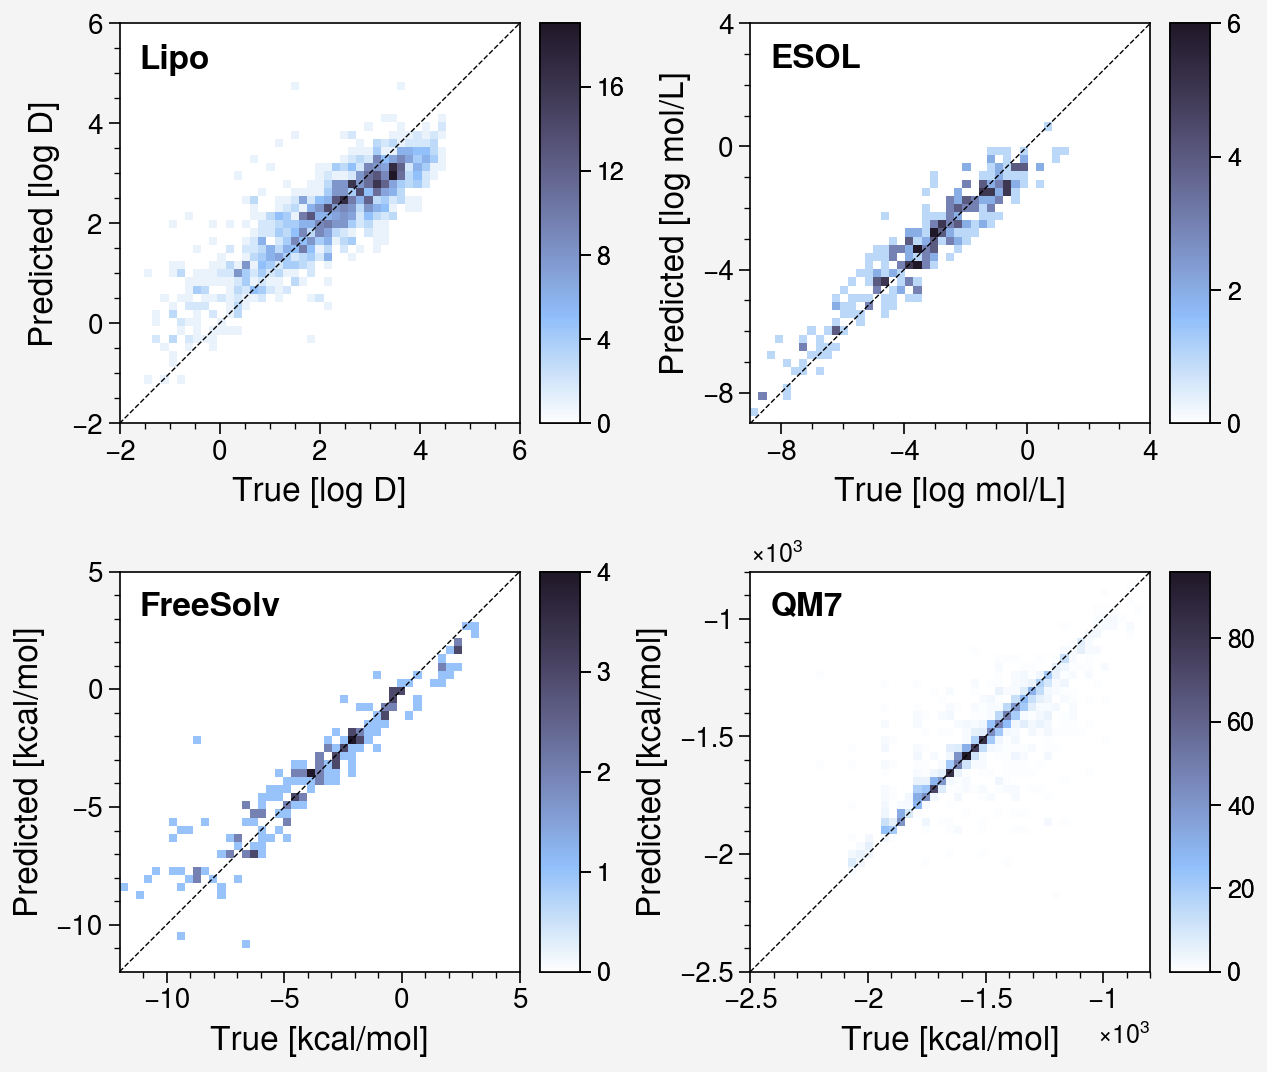

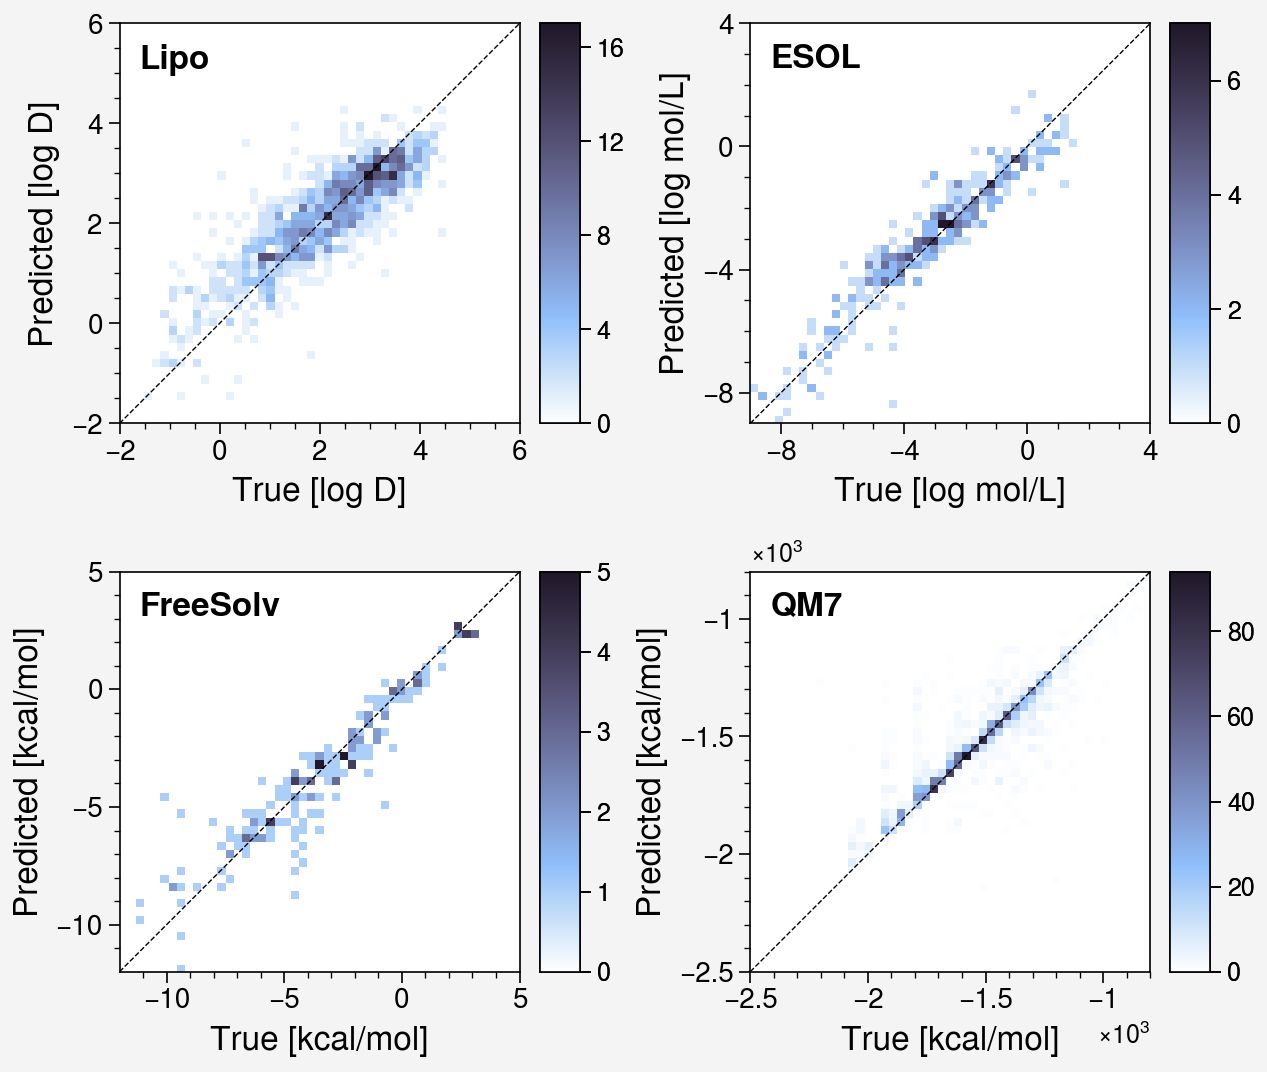

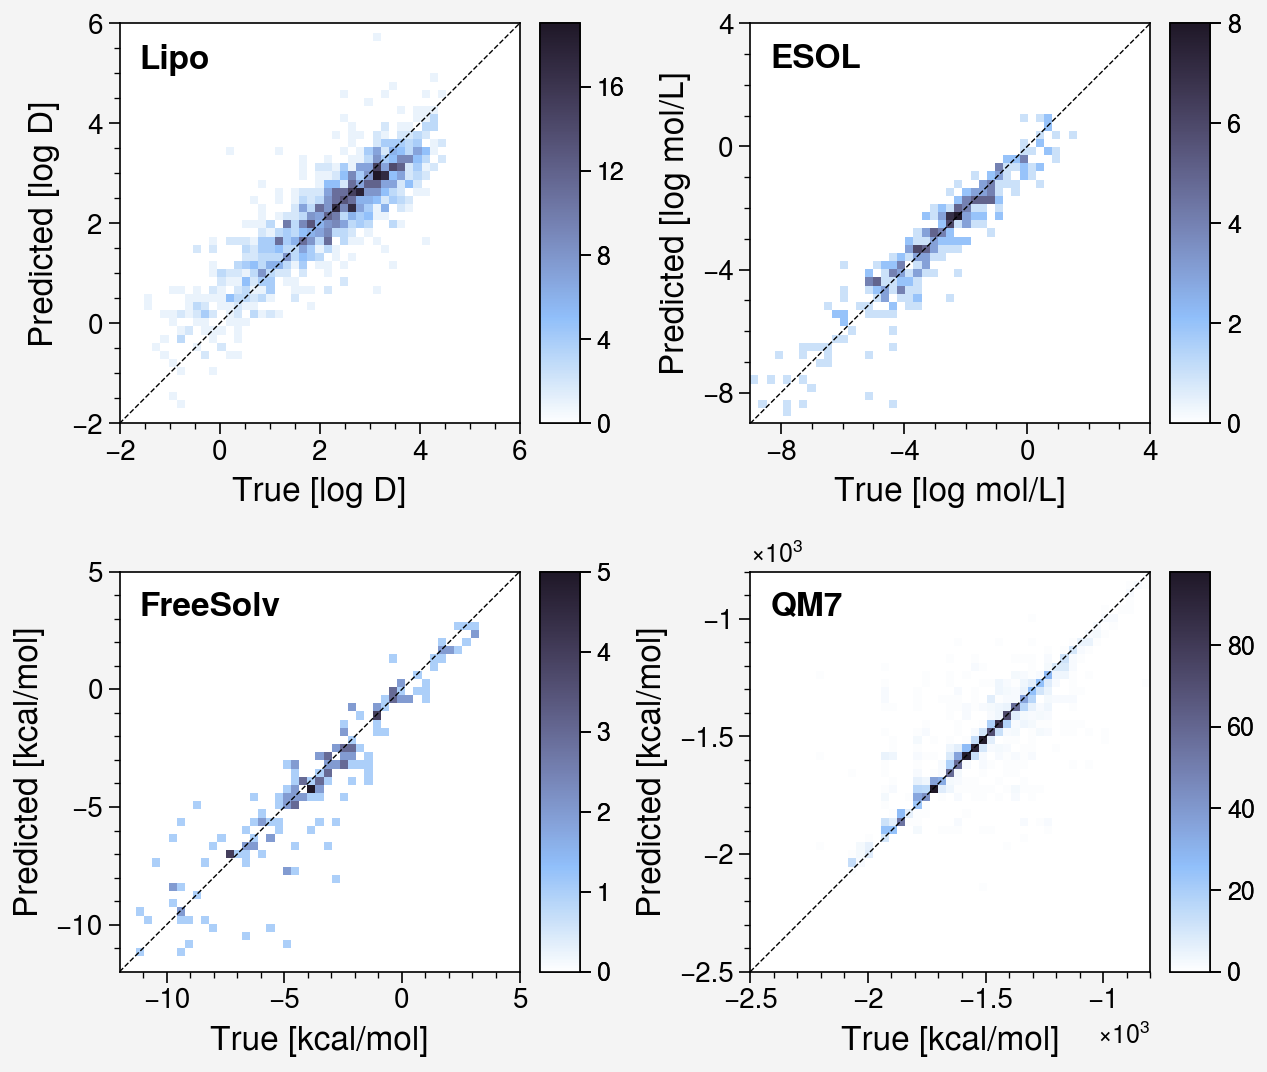

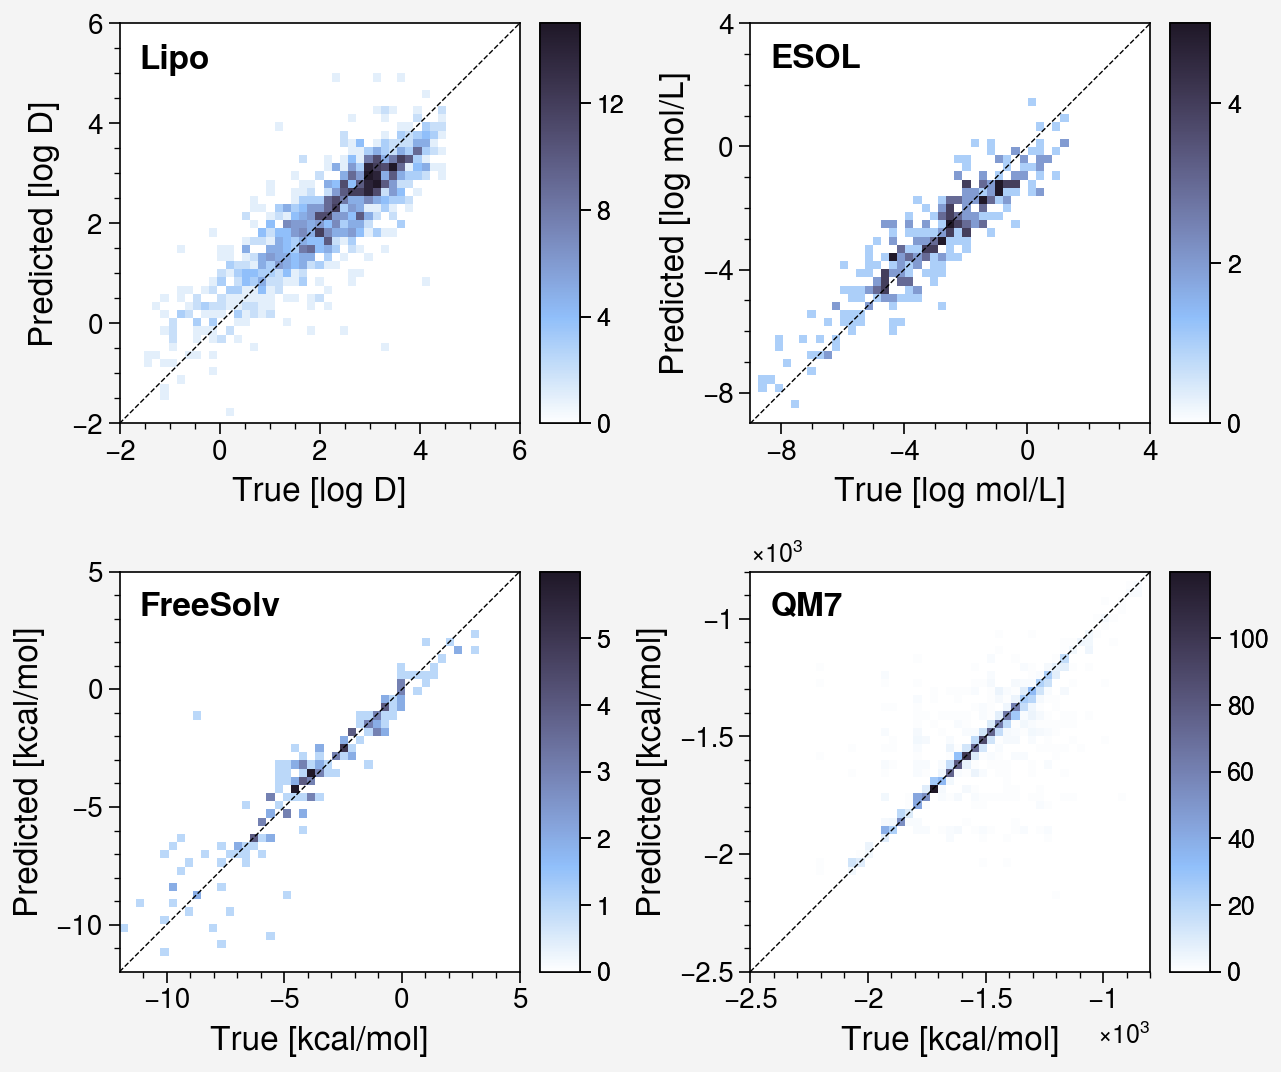

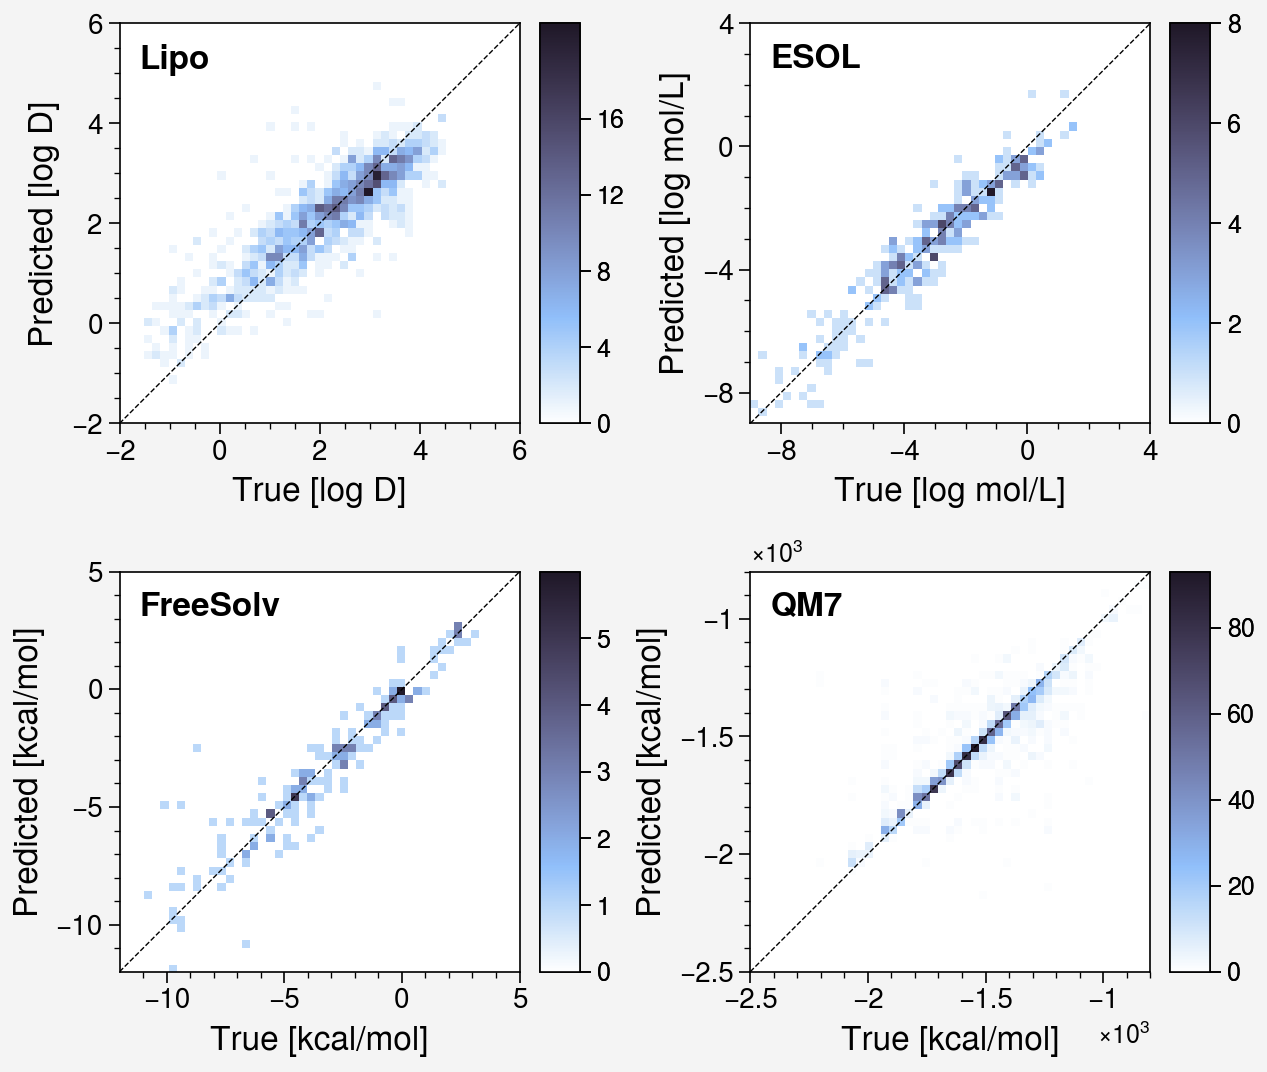

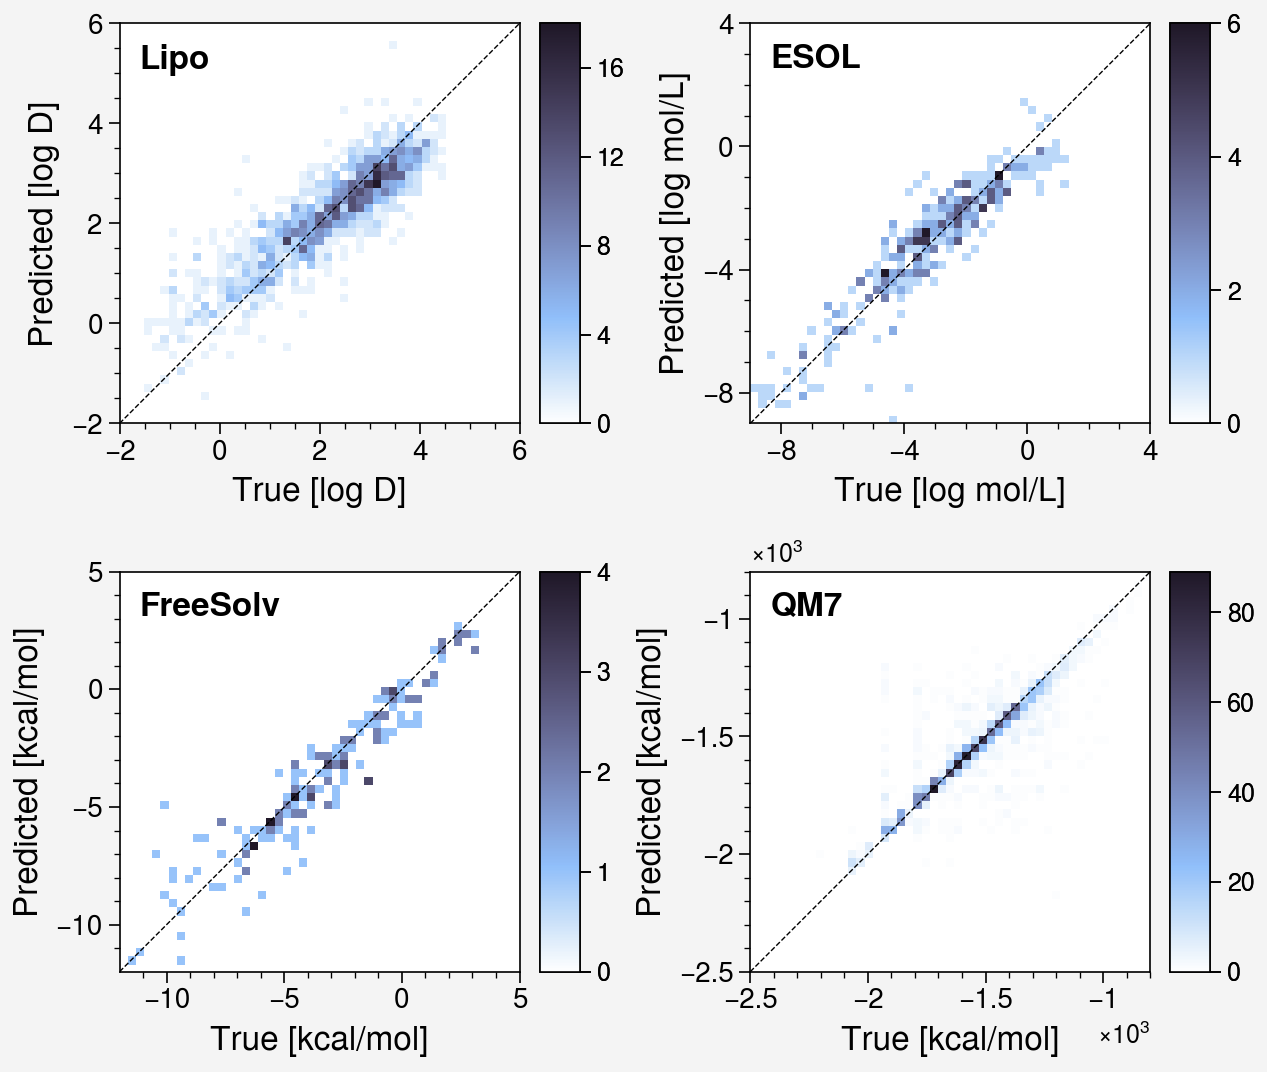

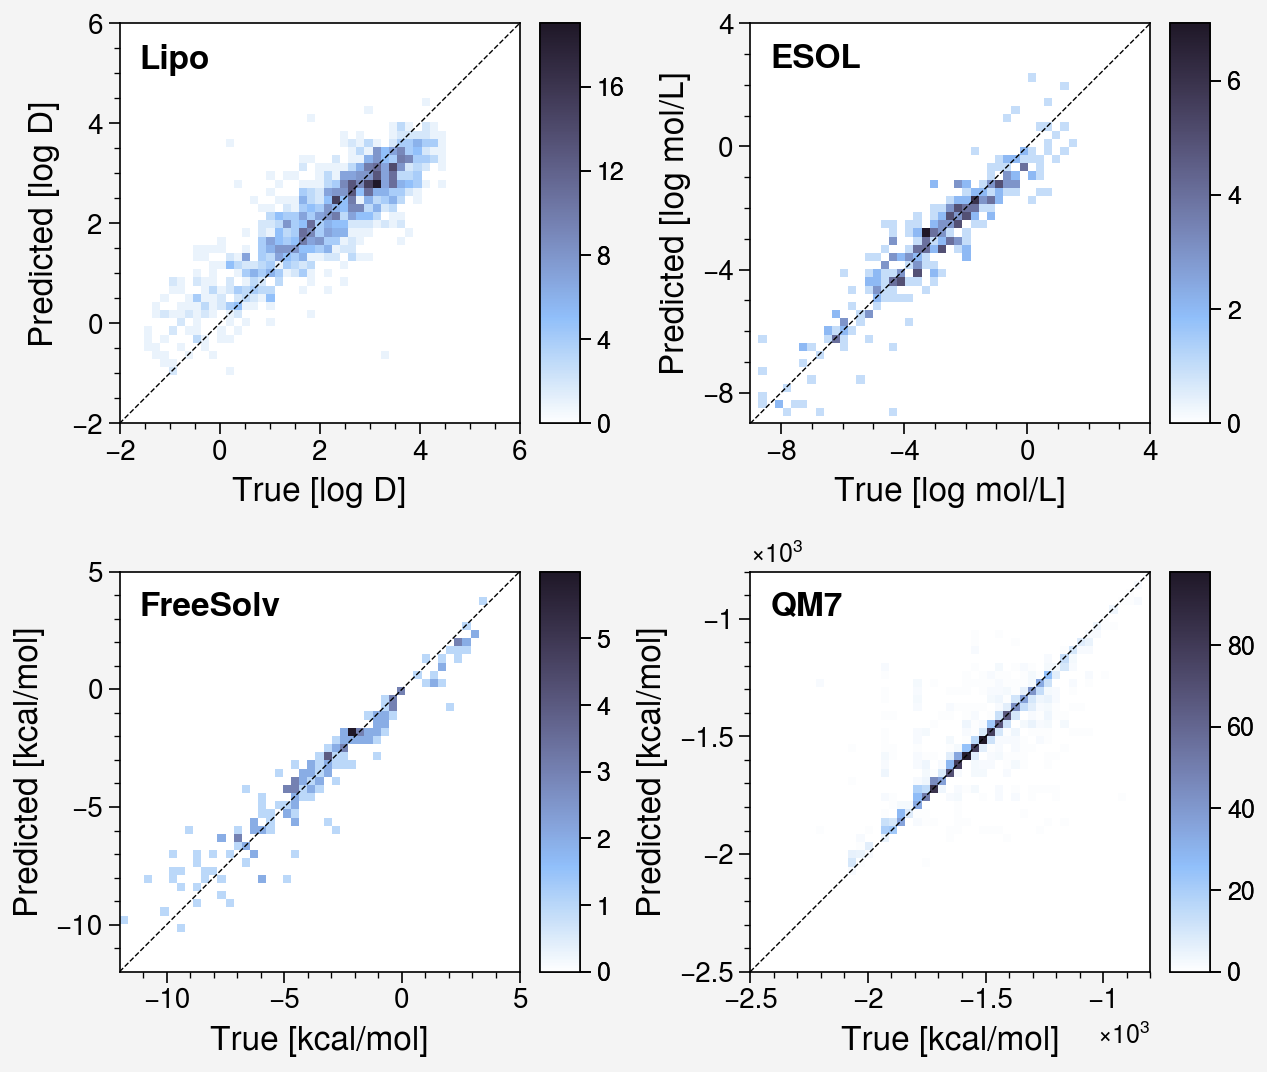

In [24]:
def parity_seed(result, dataset, ax, vmin, vmax, label, unit,
                SPLIT_TYPE="523", index=0, ticks=[0, 1, 2], colorticks=[0, 1, 2],
                seed=0):
    
    if SPLIT_TYPE == "523":
        sizes = (0.5, 0.2, 0.3)
    elif SPLIT_TYPE == "811":
        sizes = (0.8, 0.1, 0.1)
    
    
    y_true, y_pred, y_epis, y_alea, _, _, _, _ = result[(dataset, SPLIT_TYPE, seed)]

    im = ax.hist2d(y_true, y_pred, 
                   bins=np.linspace(vmin, vmax, 50), 
                   cmap='Dusk', 
                   density=False)
    
    ax.plot([vmin, vmax], [vmin, vmax], '--', c='k', lw=.5)
    ax.set_xlim([vmin, vmax])
    ax.set_ylim([vmin, vmax])
    
    ax.colorbar(im[-1], ax=ax, ticks=colorticks)
    ax.text(0.05, 0.95, label, 
            transform=ax.transAxes, 
            va='top', 
            ha='left',
            size=12, weight="bold")

    ax.format(xlabel=f'True {unit}', 
              ylabel=f'Predicted {unit}',
              xticklabelsize=10, 
              yticklabelsize=10, 
              xlabelsize=12, 
              ylabelsize=12,
              xticks=ticks,
              yticks=ticks)

for seed in range(8):
    print(f"# seed {seed} parity plot done ...")
    fig, ax = pplt.subplots(nrows=2, ncols=2, share=False, refwidth=2., refheight=2.)

    parity_seed(result, 'lipo', ax[0], 
           vmin=-2, vmax=6, 
           label='Lipo', unit=r'[log D]', 
           ticks=[-2, 0, 2, 4, 6],
           colorticks=[0, 4, 8, 12, 16],
           seed=seed)
    parity_seed(result, 'delaney', ax[1], 
           vmin=-9, vmax=4,
           label='ESOL', unit=r'[log mol/L]',
           ticks=[-8, -4, 0, 4],
           colorticks=[0, 2, 4, 6, 8],
           seed=seed)
    parity_seed(result, 'freesolv', ax[2], 
           vmin=-12, vmax=5, 
           label='FreeSolv', unit=r'[kcal/mol]',
           ticks=[-10, -5, 0, 5],
           colorticks=[0, 1, 2, 3, 4, 5],
           seed=seed)
    parity_seed(result, 'qm7', ax[3], 
           vmin=-2500, vmax=-800, 
           label='QM7', unit=r'[kcal/mol]',
           ticks=[-2500, -2000, -1500, -1000],
           colorticks=[0, 20, 40, 60, 80, 100],
           seed=seed)

    for i in [3]:
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

    fig.save(f'../result/fig/parity_single_v2_seed_{seed}.eps', bbox_inches='tight')

### Best and worst models

In [26]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

for best in range(10):
    print(f"# Best {best} model found ...")
    df = pd.read_csv(os.join(ROOT_DIR, 'NEW_RE_lipo_random_0_split_523/results.csv'))

    arch = df['p:arch_seq'][np.argsort(df['objective']).values[-best-1]]
    arch = ast.literal_eval(arch)

    input_shape = [(56, 133), (235, 2), (235, 14), (56,)]
    output_shape = (1,)

    shapes = dict(input_shape=input_shape, output_shape=output_shape)

    space = RegressionUQSpace(**shapes).build()

    model = space.sample(choice=arch)
    plot_model(model, to_file=f'../result/fig/lipo_model_{best}.png', show_shapes=False, show_layer_names=False, dpi=300, expand_nested=True, rankdir='TB')
    plot_model(model, to_file=f'../result/fig/lipo_model_{best}.pdf', show_shapes=False, show_layer_names=False, dpi=300, expand_nested=True, rankdir='TB')    

# Best 0 model found ...
# Best 1 model found ...
# Best 2 model found ...
# Best 3 model found ...
# Best 4 model found ...
# Best 5 model found ...
# Best 6 model found ...
# Best 7 model found ...
# Best 8 model found ...
# Best 9 model found ...


In [27]:
for worst in range(10):
    print(f"# Worst {worst} model found ...")
    df = pd.read_csv(os.join(ROOT_DIR, 'NEW_RE_lipo_random_0_split_523/results.csv'))

    arch = df['p:arch_seq'][np.argsort(df['objective']).values[worst]]
    arch = ast.literal_eval(arch)

    input_shape = [(56, 133), (235, 2), (235, 14), (56,)]
    output_shape = (1,)

    shapes = dict(input_shape=input_shape, output_shape=output_shape)

    space = RegressionUQSpace(**shapes).build()

    model = space.sample(choice=arch)
    plot_model(model, to_file=f'../result/fig/lipo_worst_{best}.png', show_shapes=False, show_layer_names=False, dpi=300, expand_nested=True, rankdir='TB')
    plot_model(model, to_file=f'../result/fig/lipo_worst_{best}.pdf', show_shapes=False, show_layer_names=False, dpi=300, expand_nested=True, rankdir='TB')    

# Worst 0 model found ...
# Worst 1 model found ...
# Worst 2 model found ...
# Worst 3 model found ...
# Worst 4 model found ...
# Worst 5 model found ...
# Worst 6 model found ...
# Worst 7 model found ...
# Worst 8 model found ...
# Worst 9 model found ...


In [33]:
print('Number of potential candidate models:', space.size)

Number of potential candidate models: 12259638116352
